# NFL Competition 2019
# Time: NFL Academy

- Rodrigo de Lima Oliveira: https://www.kaggle.com/rodrigolima82
- Sandro Wentz Forte: https://www.kaggle.com/wentzforte
- Daniela Aragaki: https://www.kaggle.com/daniaragaki

### Resultado: posição 158 (8%) - Medalha de Bronze

# Análise Exploratória nos dados de Treino

#### Está no Jupyter: NFL_Data_Exploration

## Importa os pacotes e o dataset de treino

In [6]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

# Statistic lib packages
from scipy import stats
from scipy.stats import skew, norm


# Utils packages
import pandasql as ps
import re 
import math, string, os
import datetime
from IPython.display import Image
from tqdm import tqdm_notebook
import codecs
import time
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [7]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam
from keras import optimizers

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection

In [8]:
# Importar o dataset de treino
# Verifica se está no ambiente do Kaggle ou na máquina local
if TRAIN_OFFLINE:
    train  = pd.read_csv('../../data/train.csv', dtype={'WindSpeed': 'object'})
else:
    train  = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

In [9]:
# Features que serao removidas no treinamento
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

# Sobre NFL

In [10]:
Image(url = 'https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3258%2F820e86013d48faacf33b7a32a15e814c%2FIncreasing%20Dir%20and%20O.png?generation=1572285857588233&alt=media')

# Feature Engineering

### Criação de várias funções que serão utilizadas na Feature Engineering

In [6]:
# Funcao para converter string para segundos
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

# Funcao para converter string para float
def strtofloat(x):
    try:
        return float(x)
    except:
        return -1

# Funcao para realizar split de time
def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

# Funcao para realizar o mapeamento da feature Weather
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

# Funcao para realizar o mapeamento da feature OffensePersonnel
def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

# Funcao para realizar o mapeamento da feature DefensePersonnel
def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

# Funcao para alterar feature de orientacao para categorica
def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"    

# Funcao generica para criar campos estatisticos com agregacoes
def uid_aggregation(comb, main_columns, uids, aggregations):
    X = pd.DataFrame()
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = comb[[col, main_column]]
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                X[new_col_name] = comb[col].map(temp_df)
                del temp_df
                gc.collect()
    return X

# Funcao para transformacao de tempo em quarter
def transform_time_quarter(str1):
    return int(str1[:2])*60 + int(str1[3:5])

# Funcao para ajustes na feature Quarter
def transform_time_all(str1,quarter):
    if quarter<=4:
        return 15*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    if quarter ==5:
        return 10*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60

# Funcao para ajuste na feature Play_Direction (coordenada X)
def new_coord_X(x_coordinate, play_direction):
    if play_direction == 'left':
        return 120.0 - x_coordinate
    else:
        return x_coordinate

# Funcao para ajuste na feature Yardline
def new_line(rush_team, field_position, yardline):
    if rush_team == field_position:
        return 10.0 + yardline
    else:
        return 60.0 + (50 - yardline)

# Funcao para ajuste na feature Yardline (ajuste no angulo)
def new_orientation(angle, play_direction):
    if play_direction == 'left':
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle

# Funcao para calcular a distancia euclidiana
def l2_norm_mat(mat_v, mat_u):
    return np.linalg.norm(mat_v - mat_u, axis=1)    

# Funcao para calculo da distancia euclidiana
def euclidean_distance(x1,y1,x2,y2):
    x_diff = (x1-x2)**2
    y_diff = (y1-y2)**2
    return np.sqrt(x_diff + y_diff)

# Funcao para calcular a distancia euclidiana
def calculate_distance(tmp): 
    mat_u = np.array(tmp[['X','Y']])
    mat_v = np.array(tmp[['Xc_def_mean','Yc_def_mean']])
    mat_w = np.array(tmp[['Xc_off_mean','Yc_off_mean']])
    mat_z = np.array(tmp[['X_rusher','Y_rusher']])
    
    tmp['dist_cdef_vs_coff'] = l2_norm_mat(mat_v, mat_w)
    tmp['dist_cdef_vs_player'] = l2_norm_mat(mat_u, mat_v)
    tmp['dist_coff_vs_player'] = l2_norm_mat(mat_u, mat_w)
    tmp['dist_cdef_vs_rusher'] = l2_norm_mat(mat_z, mat_v)
    tmp['dist_coff_vs_rusher'] = l2_norm_mat(mat_z, mat_w)
    tmp['dist_player_vs_rusher'] = l2_norm_mat(mat_u, mat_z)
    
    return tmp

# Funcao para verificar se a orientacao é maior ou menos que 180 graus
def back_direction(orientation):
    if orientation > 180.0:
        return 1
    else:
        return 0

# Funcao para calculo de velocidade
def velocity(x2, x1, sec) :
    return (x2 - x1) / sec

# Funcao para calculo de diferencas de angulos
def diff_x(b, c, theta) :
    if 90.0 < theta < 270.0 :
        return np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
    else :
        return 0

# Funcao para calculo de diferencas de angulos
def diff_y(b, c, theta) :
    if theta <= 90.0 and theta >= 270.0 :
        return - np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
    else :
        return 0

# Funcao para calculo da velocidade / aceleracao
def stop_period(speed, acc) :
    return speed / acc   

# Funcao para calculo de diferencas de angulo com base na velocidade
def new_roll_velocity(x1, y1, x2, y2) :  
    x_diff = np.sqrt((x1 - x2) ** 2)
    y_diff = np.sqrt((y1 - y2) ** 2)
    return np.sqrt(x_diff + y_diff) 

# Funcao para calcular a coordenada central do time de ataque e defesa
def add_centroid(tmp):
    df = pd.DataFrame()
    
    for col in tmp.columns:
        if col in ['X','Y']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_std']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].std()
    
    temp1= df.unstack()
    temp1.columns = ['Xc_def_mean','Xc_off_mean', 'Xc_def_std','Xc_off_std','Yc_def_mean','Yc_off_mean','Yc_def_std','Yc_off_std']

    temp2 = tmp.loc[tmp['IsRusher'] == True, ['GameId','PlayId','X','Y','Sx','Sy','Ax','Ay','F','Fx','Fy','p','px','py','pf_max','px_max','py_max']]
    temp2.columns = ['GameId','PlayId','X_rusher','Y_rusher','Sx_rusher','Sy_rusher','Ax_rusher','Ay_rusher','F_rusher','Fx_rusher','Fy_rusher','p_rusher','px_rusher','py_rusher','p_max_rusher','px_max_rusher','py_max_rusher']
    temp1 = temp1.merge(temp2, on=['GameId','PlayId'], how='left')
    new_tmp = tmp.merge(temp1, on=['GameId','PlayId'])

    return new_tmp

# Funcao para calcular a velocidade maxima dado a aceleracao
# Retornar tambem o valor F e p (absoluto e relativo)
def add_x_y_components(df):
    df['S_'] = df['S'].apply(convert_yard_to_m)
    df['A_'] = df['A'].apply(convert_yard_to_m)
    df['Sx'] = df['S']*np.cos(df['Dir'])
    df['Sy'] = df['S']*np.sin(df['Dir'])
    df['Sy_'] = np.abs(df['S']*np.sin(df['Dir'])) 
    df['Ax'] = df['A']*np.cos(df['Dir'])
    df['Ay'] = df['A']*np.sin(df['Dir'])
    df['Sfx'] = df['Sx']+df['Ax']*3.5
    df['Sfy'] = df['Sy']+df['Ay']*3.5
    df['F'] = df['PlayerWeight_kg']*df['A_']
    df['Fx'] = df['F']*np.cos(df['Dir'])
    df['Fy'] = df['F']*np.sin(df['Dir'])
    df['p'] = df['PlayerWeight_kg']*df['S_']
    df['px'] = df['p']*np.cos(df['Dir'])
    df['py'] = df['p']*np.sin(df['Dir'])
    df['pf_max'] = df['PlayerWeight_kg']*(np.sqrt(df['Sfx']**2+df['Sfy']**2)) 
    df['px_max'] = df['pf_max']*np.cos(df['Dir'])
    df['py_max'] = df['pf_max']*np.sin(df['Dir'])
    df['KE'] = (1/2) * df['PlayerWeight_kg'] * (df['S_'] ** 2)

    del df['A_']
    del df['S_']
    return df

# Funcao para calcular o tempo necessario para o primeiro down baseado na Distancia
def add_rushertimeto1stdown(data):
    tmp = data.copy()
    tmp = tmp.loc[tmp['IsRusher']==True,['GameId','PlayId','X','Sx_rusher','Ax_rusher','Dis','Distance','YardLine']]
    tmp['S0x_rusher'] = np.sqrt(np.square(tmp['Sx_rusher'])-2*(tmp['Ax_rusher'])*(tmp['Dis']))
    tmp['S0x_rusher'].fillna(np.sqrt(-np.square(tmp['Sx_rusher'])-2*(-tmp['Ax_rusher'])*(tmp['Dis'])), inplace = True)
    tmp['rusher_dist_to_yardline'] = tmp['YardLine']-tmp['X']
    tmp['rusher_dist_to_1stdown'] = tmp['rusher_dist_to_yardline'] + tmp['Distance']
    tmp['Disc_1'] = (tmp['S0x_rusher'])**2-(4*(tmp['Ax_rusher']/2)*(-tmp['rusher_dist_to_1stdown']))
    tmp['t_1stDown'] = (-tmp['S0x_rusher'] + np.sqrt(tmp['Disc_1'])/(tmp['Ax_rusher']))
    S_max_rusher = tmp.loc[tmp['Sx_rusher']>0,'Sx_rusher'].median()
    tmp['t_1stDown'].fillna(2*tmp['rusher_dist_to_1stdown']/S_max_rusher, inplace=True)
    tmp.loc[np.isneginf(tmp['t_1stDown'])==True,['t_1stDown']] = -1.0
    tmp.loc[np.isposinf(tmp['t_1stDown'])==True,['t_1stDown']] = -1.0

    col = ['Sx_rusher','Ax_rusher','Dis','Distance','Disc_1','X','YardLine','rusher_dist_to_yardline']
    tmp.drop(col,axis= 1, inplace= True)
    
    data = data.merge(tmp, on=['GameId','PlayId'], how='left')
    return data

# Funcao para calcular o tempo necessario para tackle do rusher
def calc_timetotackle(tmp): 
    df = pd.DataFrame()
    tmp = tmp.loc[tmp['IsOnOffense']==False,['GameId','PlayId','Sx','Sx_rusher','X','X_rusher','Ax','Ax_rusher','Sy','Sy_rusher','Y','Y_rusher','Ay','Ay_rusher','IsOnOffense']]
    tmp['Dx'] = np.square(tmp['Sx']-tmp['Sx_rusher'])-4*(tmp['X']-tmp['X_rusher'])*(tmp['Ax']-tmp['Ax_rusher'])/2 
    tmp['Dy'] = np.square(tmp['Sy']-tmp['Sy_rusher'])-4*(tmp['Y']-tmp['Y_rusher'])*(tmp['Ay']-tmp['Ay_rusher'])/2 
    tmp['tx'] = (-(tmp['Sx']-tmp['Sx_rusher'])-np.sqrt(tmp['Dx']))/(2*(tmp['Ax']-tmp['Ax_rusher'])/2)
    tmp['ty'] = (-(tmp['Sy']-tmp['Sy_rusher'])-np.sqrt(tmp['Dy']))/(2*(tmp['Ay']-tmp['Ay_rusher'])/2)
    tmp['tx'].fillna((-(tmp['Sx']-tmp['Sx_rusher']))/(2*(tmp['Ax']-tmp['Ax_rusher'])/2), inplace = True)
    tmp['ty'].fillna((-(tmp['Sy']-tmp['Sy_rusher']))/(2*(tmp['Ay']-tmp['Ay_rusher'])/2), inplace = True)
    tmp['time_to_tackle'] = np.sqrt(np.square(tmp['tx']) + np.square(tmp['ty']))
    
    for col in tmp.columns:
        if col in ['time_to_tackle']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_min']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].min()
            df[col+'_max']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].max()
            
    tmp2 = df.unstack()
    tmp2.columns = ['time_to_tackle_mean','time_to_tackle_min','time_to_tackle_max']
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_max'])==True,['time_to_tackle_mean','time_to_tackle_max']] = tmp2['time_to_tackle_min']
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_min'])==True,['time_to_tackle_min']] = 40
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_max'])==True,['time_to_tackle_max']] = 40
    tmp2.loc[np.isposinf(tmp2['time_to_tackle_mean'])==True,['time_to_tackle_mean']] = 40
    
    return tmp2

# Funcao para calcular a taxa de distancia entre o jogador e o rusher
def add_distance_ratios(data, encoder, deploy=False):
    tmp = data.copy()
    tmp1 = tmp.loc[:,['GameId','PlayId','IsOnOffense','IsRusher','dist_player_vs_rusher']]
    tmp1['dist_from_rusher_cat'] = tmp1['dist_player_vs_rusher'].apply(lambda x: map_distance_from_rusher(x))

    enc = encoder
    
    if not deploy:
        new_column = pd.DataFrame(enc.fit_transform(np.array(tmp1['dist_from_rusher_cat']).reshape(-1,1)))
    else:
        new_column = pd.DataFrame(enc.transform(np.array(tmp1['dist_from_rusher_cat']).reshape(-1,1)))  
    
    new_column.columns = ['D1','D2','D3','D4','D5','D6','D7']
    tmp = pd.merge(tmp, new_column, left_index=True, right_index=True,how ='left')
    tmp2 = tmp.loc[(tmp1['IsRusher']!=1)&(tmp['IsOnOffense']==1),['GameId','PlayId','NflId','IsOnOffense','dist_player_vs_rusher','dist_from_rusher_cat','D1','D2','D3','D4','D5','D6','D7']]

    df = pd.DataFrame()
    
    for col in ['D1','D2','D3','D4','D5','D6','D7']:
        df[col+'_cnt_off'] = tmp2.groupby(['GameId','PlayId'])[col].sum()

    tmp2 = tmp.loc[(tmp1['IsOnOffense']==0),['GameId','PlayId','NflId','IsOnOffense','dist_player_vs_rusher','dist_from_rusher_cat','D1','D2','D3','D4','D5','D6','D7']]

    for col in ['D1','D2','D3','D4','D5','D6','D7']:
        df[col+'_cnt_def'] = tmp2.groupby(['GameId','PlayId'])[col].sum()

    weights = [2, 0.9,0.8,0.7,0.6,0.5,0.4]
    df['dist_from_rusher_DEF'] = np.dot(df[['D1_cnt_def','D2_cnt_def','D3_cnt_def','D4_cnt_def','D5_cnt_def','D6_cnt_def','D7_cnt_def']],weights)/np.sum(weights)
    df['dist_from_rusher_OFF'] = np.dot(df[['D1_cnt_off','D2_cnt_off','D3_cnt_off','D4_cnt_off','D5_cnt_off','D6_cnt_off','D7_cnt_off']],weights)/np.sum(weights)
    df['dist_from_rusher_ratio'] = df['dist_from_rusher_OFF']/df['dist_from_rusher_DEF']
    cols = ['D1_cnt_def','D2_cnt_def','D3_cnt_def','D4_cnt_def','D5_cnt_def','D6_cnt_def','D7_cnt_def','D1_cnt_off','D2_cnt_off','D3_cnt_off','D4_cnt_off','D5_cnt_off','D6_cnt_off','D7_cnt_off']
    df.drop(cols, axis = 1, inplace = True)

    data = pd.merge(data, df, on=['GameId','PlayId'], how='left')
    return data, enc

# Funcao para converter peso em lbs para kg
def convert_to_kg(lbs):
    kg = lbs * 0.45359237
    return kg

# Funcao para converter yard to m
def convert_yard_to_m(yard):
    m = yard * 0.9144    
    return m

# Funcao para mapear a distancia do corredor
def map_distance_from_rusher(distance):
    if np.square(distance)<= np.square(1):
        return '1'
    elif np.square(distance)<= np.square(2):
        return '2'
    elif np.square(distance)<= np.square(3):
        return '3'
    elif np.square(distance)<= np.square(4):
        return '4'
    elif np.square(distance)<= np.square(5):
        return '5'
    elif np.square(distance)<= np.square(10):
        return '6'
    else:
        return '7'

# Funcao para calcular taxa entre o rusher e primeira defese
def s_ratio_runner_vs_1stdef(data):
    tmp = data.loc[((data['dist_player_vs_rusher'])==(data['dist_player_vs_rusher_min_NOnOff']))&(data['IsOnOffense']==False),['GameId','PlayId','Sx','Sx_rusher']]
    tmp['rusher_1stdef_sx_ratio'] = tmp['Sx_rusher']/tmp['Sx']
    drop = ['Sx','Sx_rusher']
    tmp.drop(drop, axis = 1, inplace = True)
    return tmp

# Funcao para calcular a distancia media e minima entre jogadores e corredor
def add_players_data(tmp):
    df = pd.DataFrame()
    
    for col in tmp.columns:
        if col in ['dist_cdef_vs_player','dist_coff_vs_player','dist_player_vs_rusher']:
            df[col+'_mean']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].mean()
            df[col+'_min']= tmp.groupby(['GameId','PlayId','IsOnOffense'])[col].min()
            
    temp1= df.unstack()
    temp1.columns = ['dist_cdef_vs_player_mean_NOnOff','dist_cdef_vs_player_mean_OnOff',
                     'dist_cdef_vs_player_min_NOnOff','dist_cdef_vs_player_min_OnOff',
                     'dist_coff_vs_player_mean_NOnOff','dist_coff_vs_player_mean_OnOff',
                     'dist_coff_vs_player_min_NOnOff','dist_coff_vs_player_min_OnOff',
                     'dist_player_vs_rusher_mean_NOnOff','dist_player_vs_rusher_mean_OnOff',
                     'dist_player_vs_rusher_min_NOnOff','dist_player_vs_rusher_min_OnOff']

    return temp1

# Funcao para mapeamento da feature Yards
def clf_yards(x):

    y = 2
    if x<= -7:
        y=0
    elif x<=-2:
        y=1
    elif x<=0:
        y=2
    elif x<=2:
        y=3
    elif x<=5:
        y=4
    elif x<=10:
        y=5
    elif x<=20:
        y=6
    elif x<=40:
        y=7
    else:
        y=8
    return y

# Funcao para combinacao das features DefensePersonnel (x) e DefenderInTheBox (y)
def fill_defendersinabox(x, y):
    if x =='4 DL, 2 LB, 5 DB':
        y = 6
    elif x =='4 DL, 3 LB, 4 DB':
        y = 7
    elif x == '3 DL, 4 LB, 4 DB':
        y = 7
    elif x == '2 DL, 4 LB, 5 DB':
        y = 6
    elif x == '3 DL, 3 LB, 5 DB':
        y = 6
    return y

# Mapeamento da feature Defense Personnel
def map_DefensePersonnel(x):
    if x =='4 DL, 2 LB, 5 DB':
        y = 0
    elif x =='4 DL, 3 LB, 4 DB':
        y = 1
    elif x == '3 DL, 4 LB, 4 DB':
        y = 2
    elif x == '2 DL, 4 LB, 5 DB':
        y = 3
    elif x == '3 DL, 3 LB, 5 DB':
        y = 4
    else:
        y = 5
    return y

# Mapeamento da feature Offense Formation
map_offense_formation = {'SINGLEBACK':0,
                         'SHOTGUN':1,
                         'I_FORM':2,
                         'PISTOL':3,
                         'JUMBO':4,
                         'WILDCAT':5,
                         'ACE':6,
                         'EMPTY':7,
                        }

### Criação de funções para criação de novas features

In [8]:
# ======================================================================
# Funcao 01 para criacao de features
def create_features_01(df, deploy=False):

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]
        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_coord_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X','Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]
        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense
            
    def rusher_features(df):
        
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Dir', 'S', 'A', 'X', 'Y']]
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS', 'RusherA', 'RusherX', 'RusherY']
       
        radian_angle = (90 - rusher['RusherDir']) * np.pi / 180.0
        v_horizontal = np.abs(rusher['RusherS'] * np.cos(radian_angle))
        v_vertical = np.abs(rusher['RusherS'] * np.sin(radian_angle)) 
       
        rusher['v_horizontal'] = v_horizontal
        rusher['v_vertical'] = v_vertical
        
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS','RusherA','RusherX', 'RusherY','v_horizontal', 'v_vertical']
        
        return rusher
    
    def static_features(df):
        
        
        add_new_feas = []

        ## Height
        df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        
        
        add_new_feas.append('PlayerHeight_dense')

        ## Time
        df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        ## Age
        seconds_in_year = 60*60*24*365.25
        df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        add_new_feas.append('PlayerAge')

        ## WindSpeed
        df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
        add_new_feas.append('WindSpeed_dense')

        ## Weather
        df['GameWeather_process'] = df['GameWeather'].str.lower()
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
        df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
        add_new_feas.append('GameWeather_dense')

        ## Orientation and Dir
        df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
        df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

        df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        add_new_feas.append("Dir_sin")
        add_new_feas.append("Dir_cos")

        ## diff Score
        df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
        add_new_feas.append("diffScoreBeforePlay")
    
        static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                                             'YardLine','Quarter','Down','Distance',
                                                                             'NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','Turf',
                                                                             'VisitorTeamAbbr','PlayDirection','GameClock','Season','Team',
                                                                             'FieldPosition','DefendersInTheBox']].drop_duplicates()

        return static_features


    def combine_features(relative_to_back, defense, rushing, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,rushing,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        
        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)

    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    rush_feats = rusher_features(df)
    basetable = combine_features(rel_back, def_feats, rush_feats, static_feats,deploy = deploy)
    
    return basetable

# ======================================================================
# Funcao 02 para criacao de features
def create_features_02(t_):
    
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))

    t_['IsRusher'] = (t_['NflId'] == t_['NflIdRusher'])
    temp = t_[t_["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    t_ = t_.merge(temp, on = "PlayId")
    t_["IsRusherTeam"] = t_["Team"] == t_["RusherTeam"]    

    t_["is_left"]            = t_["PlayDirection"] == "left"
    t_["old_data"]    = t_["Season"] == 2017
    t_['YardLine_std'] = 100 - t_['YardLine']
    
    t_['Orientation_rad'] = np.mod(t_.Orientation, 360) * np.pi/180.0
    t_.loc[t_.Season >= 2018, 'Orientation_rad'] = np.mod(t_.loc[t_.Season >= 2018, 'Orientation'] - 90, 360) * np.pi/180.0
    t_['Orientation_std'] = t_.Orientation_rad
    t_.loc[t_.is_left, 'Orientation_std'] = np.mod(np.pi + t_.loc[t_.is_left, 'Orientation_rad'], 2*np.pi)
    
    t_['norm_quat'] = (t_['X']**2 + t_['Y']**2 + t_['A']**2 + t_['S']**2)
    t_['mod_quat'] = (t_['norm_quat'])**0.5
    t_['norm_X'] = t_['X'] / t_['mod_quat']
    t_['norm_Y'] = t_['Y'] / t_['mod_quat']
    t_['norm_A'] = t_['A'] / t_['mod_quat']
    t_['norm_S'] = t_['S'] / t_['mod_quat']    

    t_['seconds_need_to_first_down'] = (t_['Distance']*0.9144)/t_['Dis']
    t_['seconds_need_to_YardsLine'] = (t_['YardLine']*0.9144)/t_['Dis']    
    t_['DefendersInTheBox_vs_Distance'] = t_['DefendersInTheBox'] / t_['Distance']    

    t_['time_quarter'] = t_.GameClock.map(lambda x:transform_time_quarter(x))
    t_['time_end'] = t_.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)

    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
            'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
            'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
            'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
            'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

    t_['Turf'] = t_['Turf'].map(Turf)
    t_['Turf'] = t_['Turf'] == 'Natural'
    
    t_ = t_.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)

    return t_

# ======================================================================
# Funcao 03 para criacao de features
def create_features_03(df, enc_in, deploy=False):

    df['IsRusher'] = df.NflId == df.NflIdRusher
    df['TeamOnOffense'] = "home"
    
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    df['PlayerWeight_kg'] = df['PlayerWeight'].apply(lambda x: convert_to_kg(x))
    df['OffenseFormation'] = df['OffenseFormation'].map(map_offense_formation)
    df['DefendersInTheBox'] = df[['DefensePersonnel','DefendersInTheBox']].apply(lambda x: fill_defendersinabox(x[0],x[1]), axis=1)
    df['DefensePersonnel'] = df['DefensePersonnel'].apply(map_DefensePersonnel)
    
    
    df = add_x_y_components(df)
    df = add_centroid(df)
    
    # Calcula o tempo necessário para fazer o primeiro down
    df = add_rushertimeto1stdown(df)
    
    # Calcular distâncias entre ataque, defesa, rusher e jogadores
    df = calculate_distance(df)
    df, enc_out = add_distance_ratios(df, encoder=enc_in, deploy=deploy)

    # Calcula o tempo para tackle
    timetotackle = calc_timetotackle(df)
    df = pd.merge(df, timetotackle, on=['GameId','PlayId'], how= 'left')
    play_data = add_players_data(df)
    df = pd.merge(df, play_data, on=['GameId','PlayId'], how= 'left')
    
    # Calcula a relação entre as velocidades do rusher e do defensor mais próximo
    to_merge_S = s_ratio_runner_vs_1stdef(df)
    df = pd.merge(df, to_merge_S, on=['GameId','PlayId'], how='left')
    
    df = df.loc[df['IsRusher']==1,:]
    
    # Colunas que serao removidas
    cols = [ 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId', 'DisplayName',
            'JerseyNumber', 'Season', 'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance', 
            'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher', 
            'OffensePersonnel', 'PlayDirection', 'TimeHandoff', 'TimeSnap', 'PlayerHeight', 'PlayerWeight', 
            'PlayerBirthDate', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 
            'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'Temperature',
            'Humidity', 'WindSpeed', 'WindDirection', 'YardLine', 'IsRusher', 'TeamOnOffense', 
            'IsOnOffense', 'PlayerWeight_kg','X_rusher','Y_rusher','Sx_rusher','Sy_rusher','Ax_rusher',
            'Ay_rusher','F_rusher','Fx_rusher','Fy_rusher','p_rusher','px_rusher','py_rusher','p_max_rusher',
            'px_max_rusher','py_max_rusher','dist_player_vs_rusher']
    df.drop(cols, axis=1, inplace=True)
    feat = [col for col in df.columns if col not in ['Yards']]
    df = df[feat]
    
    return df, enc_out

### Realizando a criaçao de features 01

In [11]:
%time train_basetable_01 = create_features_01(train, False)

CPU times: user 5min 14s, sys: 5.94 s, total: 5min 20s
Wall time: 5min 19s


In [12]:
train_basetable_01.head()

GameId          PlayId  back_from_scrimmage  back_oriented_down_field  \
0  2017090700  20170907000118                 3.75                         1   
1  2017090700  20170907000139                 4.07                         0   
2  2017090700  20170907000189                 3.66                         1   
3  2017090700  20170907000345                 3.53                         0   
4  2017090700  20170907000395                 5.01                         0   

   back_moving_down_field  min_dist   max_dist  mean_dist  std_dist  \
0                       0  1.449724  22.415872   8.046559  4.873845   
1                       0  0.792023  23.025872   8.614623  5.598683   
2                       0  1.646390  20.726285   8.482583  4.642121   
3                       0  0.918096   9.791231   5.549379  1.983128   
4                       0  0.502892  21.214806   9.168819  5.611232   

   def_min_dist  def_max_dist  def_mean_dist  def_std_dist  RusherDir  \
0      4.593310     22.415872       9.752491      5.327299     114.26   
1      4.287773     23.025872      10.297028      5.833217      47.80   
2      4.221670     20.726285       9.903689      5.073290     138.04   
3      4.528002      9.791231       6.309354      1.834174      84.56   
4      4.288088     21.214806      11.056456      5.900009     157.92   

   RusherS  RusherA  RusherX  RusherY  v_horizontal  v_vertical  \
0     3.63     3.35    41.25    30.53      3.309436    1.491487   
1     3.06     2.41    48.93    27.16      2.266862    2.055465   
2     5.77     2.42    71.34    19.11      3.857889    4.290640   
3     4.45     3.20   104.47    25.36      4.429957    0.421875   
4     3.90     2.53    29.99    27.12      1.466013    3.613974   

   PlayerHeight_dense  PlayerAge  WindSpeed_dense  GameWeather_dense  \
0                  70  25.596251              8.0                1.0   
1                  70  25.596252              8.0                1.0   
2                  70  25.596253              8.0                1.0   
3                  71  26.852933              8.0                1.0   
4                  71  22.091819              8.0                1.0   

    Dir_sin   Dir_cos  diffScoreBeforePlay       X      Y     S     A   Dis  \
0  0.911690 -0.410878                    0   41.25  30.53  3.63  3.35  0.38   
1  0.740805  0.671721                    0   48.93  27.16  3.06  2.41  0.34   
2  0.668612 -0.743612                    0   71.34  19.11  5.77  2.42  0.60   
3  0.995496  0.094803                    0  104.47  25.36  4.45  3.20  0.46   
4  0.375901 -0.926660                    7   29.99  27.12  3.90  2.53  0.44   

   Orientation     Dir  YardLine  Quarter  Down  Distance    NflId  \
0       198.02  114.26      45.0        1     3         2  2543773   
1       149.30   47.80      53.0        1     1        10  2543773   
2       219.18  138.04      75.0        1     1        10  2543773   
3       173.78   84.56     108.0        1     2         2  2539663   
4        34.27  157.92      35.0        1     1        10  2557917   

   NflIdRusher PossessionTeam HomeTeamAbbr        Turf VisitorTeamAbbr  \
0      2543773             NE           NE  Field Turf              KC   
1      2543773             NE           NE  Field Turf              KC   
2      2543773             NE           NE  Field Turf              KC   
3      2539663             NE           NE  Field Turf              KC   
4      2557917             KC           NE  Field Turf              KC   

  PlayDirection GameClock  Season  Team FieldPosition  DefendersInTheBox  \
0          left  14:14:00    2017  home            NE                6.0   
1          left  13:52:00    2017  home            NE                6.0   
2          left  13:02:00    2017  home            KC                7.0   
3          left  12:12:00    2017  home            KC                9.0   
4         right  12:08:00    2017  away            KC                7.0   

   Yards  
0      8  
1   

### Realizando a criaçao de features 02

In [13]:
%time train_basetable_02 = create_features_02(train_basetable_01)

CPU times: user 2.89 s, sys: 20 ms, total: 2.91 s
Wall time: 2.84 s


In [14]:
train_basetable_02.head()

GameId          PlayId  back_from_scrimmage  back_oriented_down_field  \
0  2017090700  20170907000118                 3.75                         1   
1  2017090700  20170907000139                 4.07                         0   
2  2017090700  20170907000189                 3.66                         1   
3  2017090700  20170907000345                 3.53                         0   
4  2017090700  20170907000395                 5.01                         0   

   back_moving_down_field  min_dist   max_dist  mean_dist  std_dist  \
0                       0  1.449724  22.415872   8.046559  4.873845   
1                       0  0.792023  23.025872   8.614623  5.598683   
2                       0  1.646390  20.726285   8.482583  4.642121   
3                       0  0.918096   9.791231   5.549379  1.983128   
4                       0  0.502892  21.214806   9.168819  5.611232   

   def_min_dist  def_max_dist  def_mean_dist  def_std_dist  RusherDir  \
0      4.593310     22.415872       9.752491      5.327299     114.26   
1      4.287773     23.025872      10.297028      5.833217      47.80   
2      4.221670     20.726285       9.903689      5.073290     138.04   
3      4.528002      9.791231       6.309354      1.834174      84.56   
4      4.288088     21.214806      11.056456      5.900009     157.92   

   RusherS  RusherA  RusherX  RusherY  v_horizontal  v_vertical  \
0     3.63     3.35    41.25    30.53      3.309436    1.491487   
1     3.06     2.41    48.93    27.16      2.266862    2.055465   
2     5.77     2.42    71.34    19.11      3.857889    4.290640   
3     4.45     3.20   104.47    25.36      4.429957    0.421875   
4     3.90     2.53    29.99    27.12      1.466013    3.613974   

   PlayerHeight_dense  PlayerAge  WindSpeed_dense  GameWeather_dense  \
0                  70  25.596251              8.0                1.0   
1                  70  25.596252              8.0                1.0   
2                  70  25.596253              8.0                1.0   
3                  71  26.852933              8.0                1.0   
4                  71  22.091819              8.0                1.0   

    Dir_sin   Dir_cos  diffScoreBeforePlay       X      Y     S     A   Dis  \
0  0.911690 -0.410878                    0   41.25  30.53  3.63  3.35  0.38   
1  0.740805  0.671721                    0   48.93  27.16  3.06  2.41  0.34   
2  0.668612 -0.743612                    0   71.34  19.11  5.77  2.42  0.60   
3  0.995496  0.094803                    0  104.47  25.36  4.45  3.20  0.46   
4  0.375901 -0.926660                    7   29.99  27.12  3.90  2.53  0.44   

   Orientation     Dir  YardLine  Quarter  Down  Distance    NflId  \
0       198.02  114.26      45.0        1     3         2  2543773   
1       149.30   47.80      53.0        1     1        10  2543773   
2       219.18  138.04      75.0        1     1        10  2543773   
3       173.78   84.56     108.0        1     2         2  2539663   
4        34.27  157.92      35.0        1     1        10  2557917   

   NflIdRusher PossessionTeam HomeTeamAbbr   Turf VisitorTeamAbbr  \
0      2543773             NE           NE  False              KC   
1      2543773             NE           NE  False              KC   
2      2543773             NE           NE  False              KC   
3      2539663             NE           NE  False              KC   
4      2557917             KC           NE  False              KC   

  PlayDirection GameClock  Season  Team FieldPosition  DefendersInTheBox  \
0          left  14:14:00    2017  home            NE                6.0   
1          left  13:52:00    2017  home            NE                6.0   
2          left  13:02:00    2017  home            KC                7.0   
3          left  12:12:00    2017  home            KC                9.0   
4         right  12:08:00    2017  away            KC                7.0   

   Yards         fe1      fe5  fe7       fe8      fe10  

In [15]:
train_basetable_02.shape

(23171, 76)

In [16]:
# Remove alguns outliers
train_basetable_02['count'] = train_basetable_02.groupby('Yards')['Yards'].transform('count')
train_basetable_02 = train_basetable_02[train_basetable_02['count'] > 1]
train_basetable_02.shape

(23158, 77)

### Realizando a criaçao de features 03

In [17]:
%time train_basetable_03, enc_out = create_features_03(train, OneHotEncoder(handle_unknown='ignore', sparse = False), False)

CPU times: user 1min 5s, sys: 14.6 s, total: 1min 20s
Wall time: 1min 17s


In [18]:
train_basetable_03.head()

GameId          PlayId  OffenseFormation  DefendersInTheBox  \
18  2017090700  20170907000118               1.0                6.0   
40  2017090700  20170907000139               1.0                6.0   
62  2017090700  20170907000189               0.0                7.0   
84  2017090700  20170907000345               4.0                9.0   
98  2017090700  20170907000395               1.0                7.0   

    DefensePersonnel        Sx        Sy       Sy_        Ax        Ay  \
18                 5  1.440730  3.331846  3.331846  1.329599  3.074844   
40                 5 -2.386839 -1.914837  1.914837 -1.879831 -1.508090   
62                 5  5.666081 -1.090151  1.090151  2.376415 -0.457221   
84                 5 -4.296982  1.156912  1.156912 -3.089965  0.831936   
98                 5  2.602038  2.905064  2.905064  1.687989  1.884567   

          Sfx        Sfy           F          Fx          Fy           p  \
18   6.094328  14.093800  284.839770  113.051571  261.444137  308.647273   
40  -8.966246  -7.193153  204.914581 -159.835978 -128.228100  260.181999   
62  13.983534  -2.690424  205.764849  202.058969  -38.876032  490.604618   
84 -15.111858   4.068689  278.721988 -269.137843   72.462185  387.597765   
98   8.509999   9.501050  226.660702  151.225586  168.836892  349.397921   

            px          py       pf_max       px_max       py_max  \
18  122.500658  283.296184  1427.806722   566.689806  1310.532221   
40 -202.945266 -162.812442  1068.879080  -833.739270  -668.865695   
62  481.768700  -92.692026  1324.126847  1300.278972  -250.172941   
84 -374.269813  100.767725  1490.731324 -1439.470978   387.560555   
98  233.114540  260.262403  1249.683267   833.775252   930.874372   

             KE  Xc_def_mean  Xc_off_mean  Xc_def_std  Xc_off_std  \
18   512.242125    48.179091    44.057273    5.294079    1.772665   
40   364.002942    56.561818    51.867273    5.406292    2.001380   
62  1294.236570    78.389091    74.848182    4.720893    2.115286   
84   788.583156   109.310909   107.719091    0.962418    1.898686   
98   623.004444    38.413636    33.135455    5.391251    2.056883   

    Yc_def_mean  Yc_off_mean  Yc_def_std  Yc_off_std  S0x_rusher  \
18    28.890909    28.535455    7.014714    5.855606    1.032089   
40    24.892727    24.762727    7.190716    6.932502    2.641076   
62    22.602727    21.450909    6.577620    6.044208    5.408583   
84    25.733636    25.800000    4.505029    3.154869    4.615931   
98    26.586364    27.061818    7.864325    7.423977    2.298950   

    rusher_dist_to_1stdown  t_1stDown  dist_cdef_vs_coff  dist_cdef_vs_player  \
18                   -4.25  -3.125090           4.137117             7.120317   
40                    4.07   2.992733           4.696345             7.961481   
62                  -26.34 -19.368206           3.723536             7.866945   
84                 -100.47 -12.817239           1.593201             4.855307   
98                    5.01   0.492278           5.299553             8.440522   

    dist_coff_vs_player  dist_cdef_vs_rusher  dist_coff_vs_rusher  \
18             3.443689             7.120317             3.443689   
40             3.791370             7.961481             3.791370   
62             4.217487             7.866945             4.217487   
84             3.278749             4.855307             3.278749   
98             3.145993             8.440522             3.145993   

    dist_from_rusher_DEF  dist_from_rusher_OFF  dist_from_rusher_ratio  \
18              0.898305              0.983051                1.094340   
40              0.864407              1.152542                1.333333   
62              0.898305              0.915254                1.018868   
84              1.000000              1.203390                1.203390   
98              0.864407              1.118644                1.294118   

    time_to_tackle_mean  time_to_tackle_min  time_to_tackle_max  \
18             3.344904   

### Merge de todos os datasets com novas features

In [19]:
X = pd.merge(train_basetable_02, train_basetable_03, on=['GameId','PlayId'], how='inner')
X.shape

(23158, 132)

In [20]:
X.head()

GameId          PlayId  back_from_scrimmage  back_oriented_down_field  \
0  2017090700  20170907000118                 3.75                         1   
1  2017090700  20170907000139                 4.07                         0   
2  2017090700  20170907000189                 3.66                         1   
3  2017090700  20170907000345                 3.53                         0   
4  2017090700  20170907000395                 5.01                         0   

   back_moving_down_field  min_dist   max_dist  mean_dist  std_dist  \
0                       0  1.449724  22.415872   8.046559  4.873845   
1                       0  0.792023  23.025872   8.614623  5.598683   
2                       0  1.646390  20.726285   8.482583  4.642121   
3                       0  0.918096   9.791231   5.549379  1.983128   
4                       0  0.502892  21.214806   9.168819  5.611232   

   def_min_dist  def_max_dist  def_mean_dist  def_std_dist  RusherDir  \
0      4.593310     22.415872       9.752491      5.327299     114.26   
1      4.287773     23.025872      10.297028      5.833217      47.80   
2      4.221670     20.726285       9.903689      5.073290     138.04   
3      4.528002      9.791231       6.309354      1.834174      84.56   
4      4.288088     21.214806      11.056456      5.900009     157.92   

   RusherS  RusherA  RusherX  RusherY  v_horizontal  v_vertical  \
0     3.63     3.35    41.25    30.53      3.309436    1.491487   
1     3.06     2.41    48.93    27.16      2.266862    2.055465   
2     5.77     2.42    71.34    19.11      3.857889    4.290640   
3     4.45     3.20   104.47    25.36      4.429957    0.421875   
4     3.90     2.53    29.99    27.12      1.466013    3.613974   

   PlayerHeight_dense  PlayerAge  WindSpeed_dense  GameWeather_dense  \
0                  70  25.596251              8.0                1.0   
1                  70  25.596252              8.0                1.0   
2                  70  25.596253              8.0                1.0   
3                  71  26.852933              8.0                1.0   
4                  71  22.091819              8.0                1.0   

    Dir_sin   Dir_cos  diffScoreBeforePlay       X      Y     S     A   Dis  \
0  0.911690 -0.410878                    0   41.25  30.53  3.63  3.35  0.38   
1  0.740805  0.671721                    0   48.93  27.16  3.06  2.41  0.34   
2  0.668612 -0.743612                    0   71.34  19.11  5.77  2.42  0.60   
3  0.995496  0.094803                    0  104.47  25.36  4.45  3.20  0.46   
4  0.375901 -0.926660                    7   29.99  27.12  3.90  2.53  0.44   

   Orientation     Dir  YardLine  Quarter  Down  Distance    NflId  \
0       198.02  114.26      45.0        1     3         2  2543773   
1       149.30   47.80      53.0        1     1        10  2543773   
2       219.18  138.04      75.0        1     1        10  2543773   
3       173.78   84.56     108.0        1     2         2  2539663   
4        34.27  157.92      35.0        1     1        10  2557917   

   NflIdRusher PossessionTeam HomeTeamAbbr   Turf VisitorTeamAbbr  \
0      2543773             NE           NE  False              KC   
1      2543773             NE           NE  False              KC   
2      2543773             NE           NE  False              KC   
3      2539663             NE           NE  False              KC   
4      2557917             KC           NE  False              KC   

  PlayDirection GameClock  Season  Team FieldPosition  DefendersInTheBox_x  \
0          left  14:14:00    2017  home            NE                  6.0   
1          left  13:52:00    2017  home            NE                  6.0   
2          left  13:02:00    2017  home            KC                  7.0   
3          left  12:12:00    2017  home            KC                  9.0   
4         right  12:08:00    2017  away            KC                  7.0   

   Yards         fe1      fe5  fe7       fe8

In [21]:
# Remover algumas colunas que nao serao utilizadas para o treinamento
X.drop(['count','GameId','PlayId','NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr',
        'PlayDirection','GameClock','Season','Team','FieldPosition','IsRusher','IsRusherTeam','RusherTeam',
        'OffenseFormation','DefensePersonnel'], axis=1,inplace=True)

### Verificando dados missing apos feature engineering

In [22]:
# Criando uma funcao para verificar dados missing
def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Nao há dados missing no dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

In [23]:
check_missing(X, 5)

Missing n  % Missing
WindSpeed_dense                     3064  13.230849
rusher_1stdef_sx_ratio                 4   0.017273
DefendersInTheBox_x                    3   0.012954
DefendersInTheBox_vs_Distance          3   0.012954
Sx                                     0   0.000000

In [24]:
# Preenchendo os dados missing com -999
X.fillna(-999,inplace=True)

In [25]:
# Verificando se existem dados missing no dataset apos Feature Engineering
check_missing(X, 8)

Great! There are no missing values in this dataset.


### Criando uma copia do dataset para realizar Feature Selection

In [26]:
new_X = X.copy()
new_X = X.loc[:,X.columns]
new_X.head()

back_from_scrimmage  back_oriented_down_field  back_moving_down_field  \
0                 3.75                         1                       0   
1                 4.07                         0                       0   
2                 3.66                         1                       0   
3                 3.53                         0                       0   
4                 5.01                         0                       0   

   min_dist   max_dist  mean_dist  std_dist  def_min_dist  def_max_dist  \
0  1.449724  22.415872   8.046559  4.873845      4.593310     22.415872   
1  0.792023  23.025872   8.614623  5.598683      4.287773     23.025872   
2  1.646390  20.726285   8.482583  4.642121      4.221670     20.726285   
3  0.918096   9.791231   5.549379  1.983128      4.528002      9.791231   
4  0.502892  21.214806   9.168819  5.611232      4.288088     21.214806   

   def_mean_dist  def_std_dist  RusherDir  RusherS  RusherA  RusherX  RusherY  \
0       9.752491      5.327299     114.26     3.63     3.35    41.25    30.53   
1      10.297028      5.833217      47.80     3.06     2.41    48.93    27.16   
2       9.903689      5.073290     138.04     5.77     2.42    71.34    19.11   
3       6.309354      1.834174      84.56     4.45     3.20   104.47    25.36   
4      11.056456      5.900009     157.92     3.90     2.53    29.99    27.12   

   v_horizontal  v_vertical  PlayerHeight_dense  PlayerAge  WindSpeed_dense  \
0      3.309436    1.491487                  70  25.596251              8.0   
1      2.266862    2.055465                  70  25.596252              8.0   
2      3.857889    4.290640                  70  25.596253              8.0   
3      4.429957    0.421875                  71  26.852933              8.0   
4      1.466013    3.613974                  71  22.091819              8.0   

   GameWeather_dense   Dir_sin   Dir_cos  diffScoreBeforePlay       X      Y  \
0                1.0  0.911690 -0.410878                    0   41.25  30.53   
1                1.0  0.740805  0.671721                    0   48.93  27.16   
2                1.0  0.668612 -0.743612                    0   71.34  19.11   
3                1.0  0.995496  0.094803                    0  104.47  25.36   
4                1.0  0.375901 -0.926660                    7   29.99  27.12   

      S     A   Dis  Orientation     Dir  YardLine  Quarter  Down  Distance  \
0  3.63  3.35  0.38       198.02  114.26      45.0        1     3         2   
1  3.06  2.41  0.34       149.30   47.80      53.0        1     1        10   
2  5.77  2.42  0.60       219.18  138.04      75.0        1     1        10   
3  4.45  3.20  0.46       173.78   84.56     108.0        1     2         2   
4  3.90  2.53  0.44        34.27  157.92      35.0        1     1        10   

    Turf  DefendersInTheBox_x  Yards         fe1      fe5  fe7       fe8  \
0  False                  6.0      8   27.739531  15.7229  0.0  0.130860   
1  False                  6.0      3   40.699869  11.0024  0.0  0.075185   
2  False                  7.0      5   68.732841  36.1969  0.0  0.083948   
3  False                  9.0      2  101.345209  22.7465  0.0  0.043909   
4  False                  7.0      7   12.802566  17.4364  0.0  0.304626   

       fe10      fe11  is_left  old_data  YardLine_std  Orientation_rad  \
0  3.309436  1.491487     True      True          55.0         3.456101   
1  2.266862  2.055465     True      True          47.0         2.605777   
2  3.857889  4.290640     True      True          25.0         3.825413   
3  4.429957  0.421875     True      True          -8.0         3.033033   
4  1.466013  3.613974    False      True          65.0         0.598124   

   Orientation_std   norm_quat    mod_quat    norm_X    norm_Y    norm_A  \
0         0.314508   2658.0428   51.556210  0.800098  0.592169  0.064978   
1         5.747369   3146.9822   56.097970  0.872224  0.484153  0.042961   
2         0.683820   5493.7370   74.11974

### Verificando o gráfico de correlação (Heatmap)

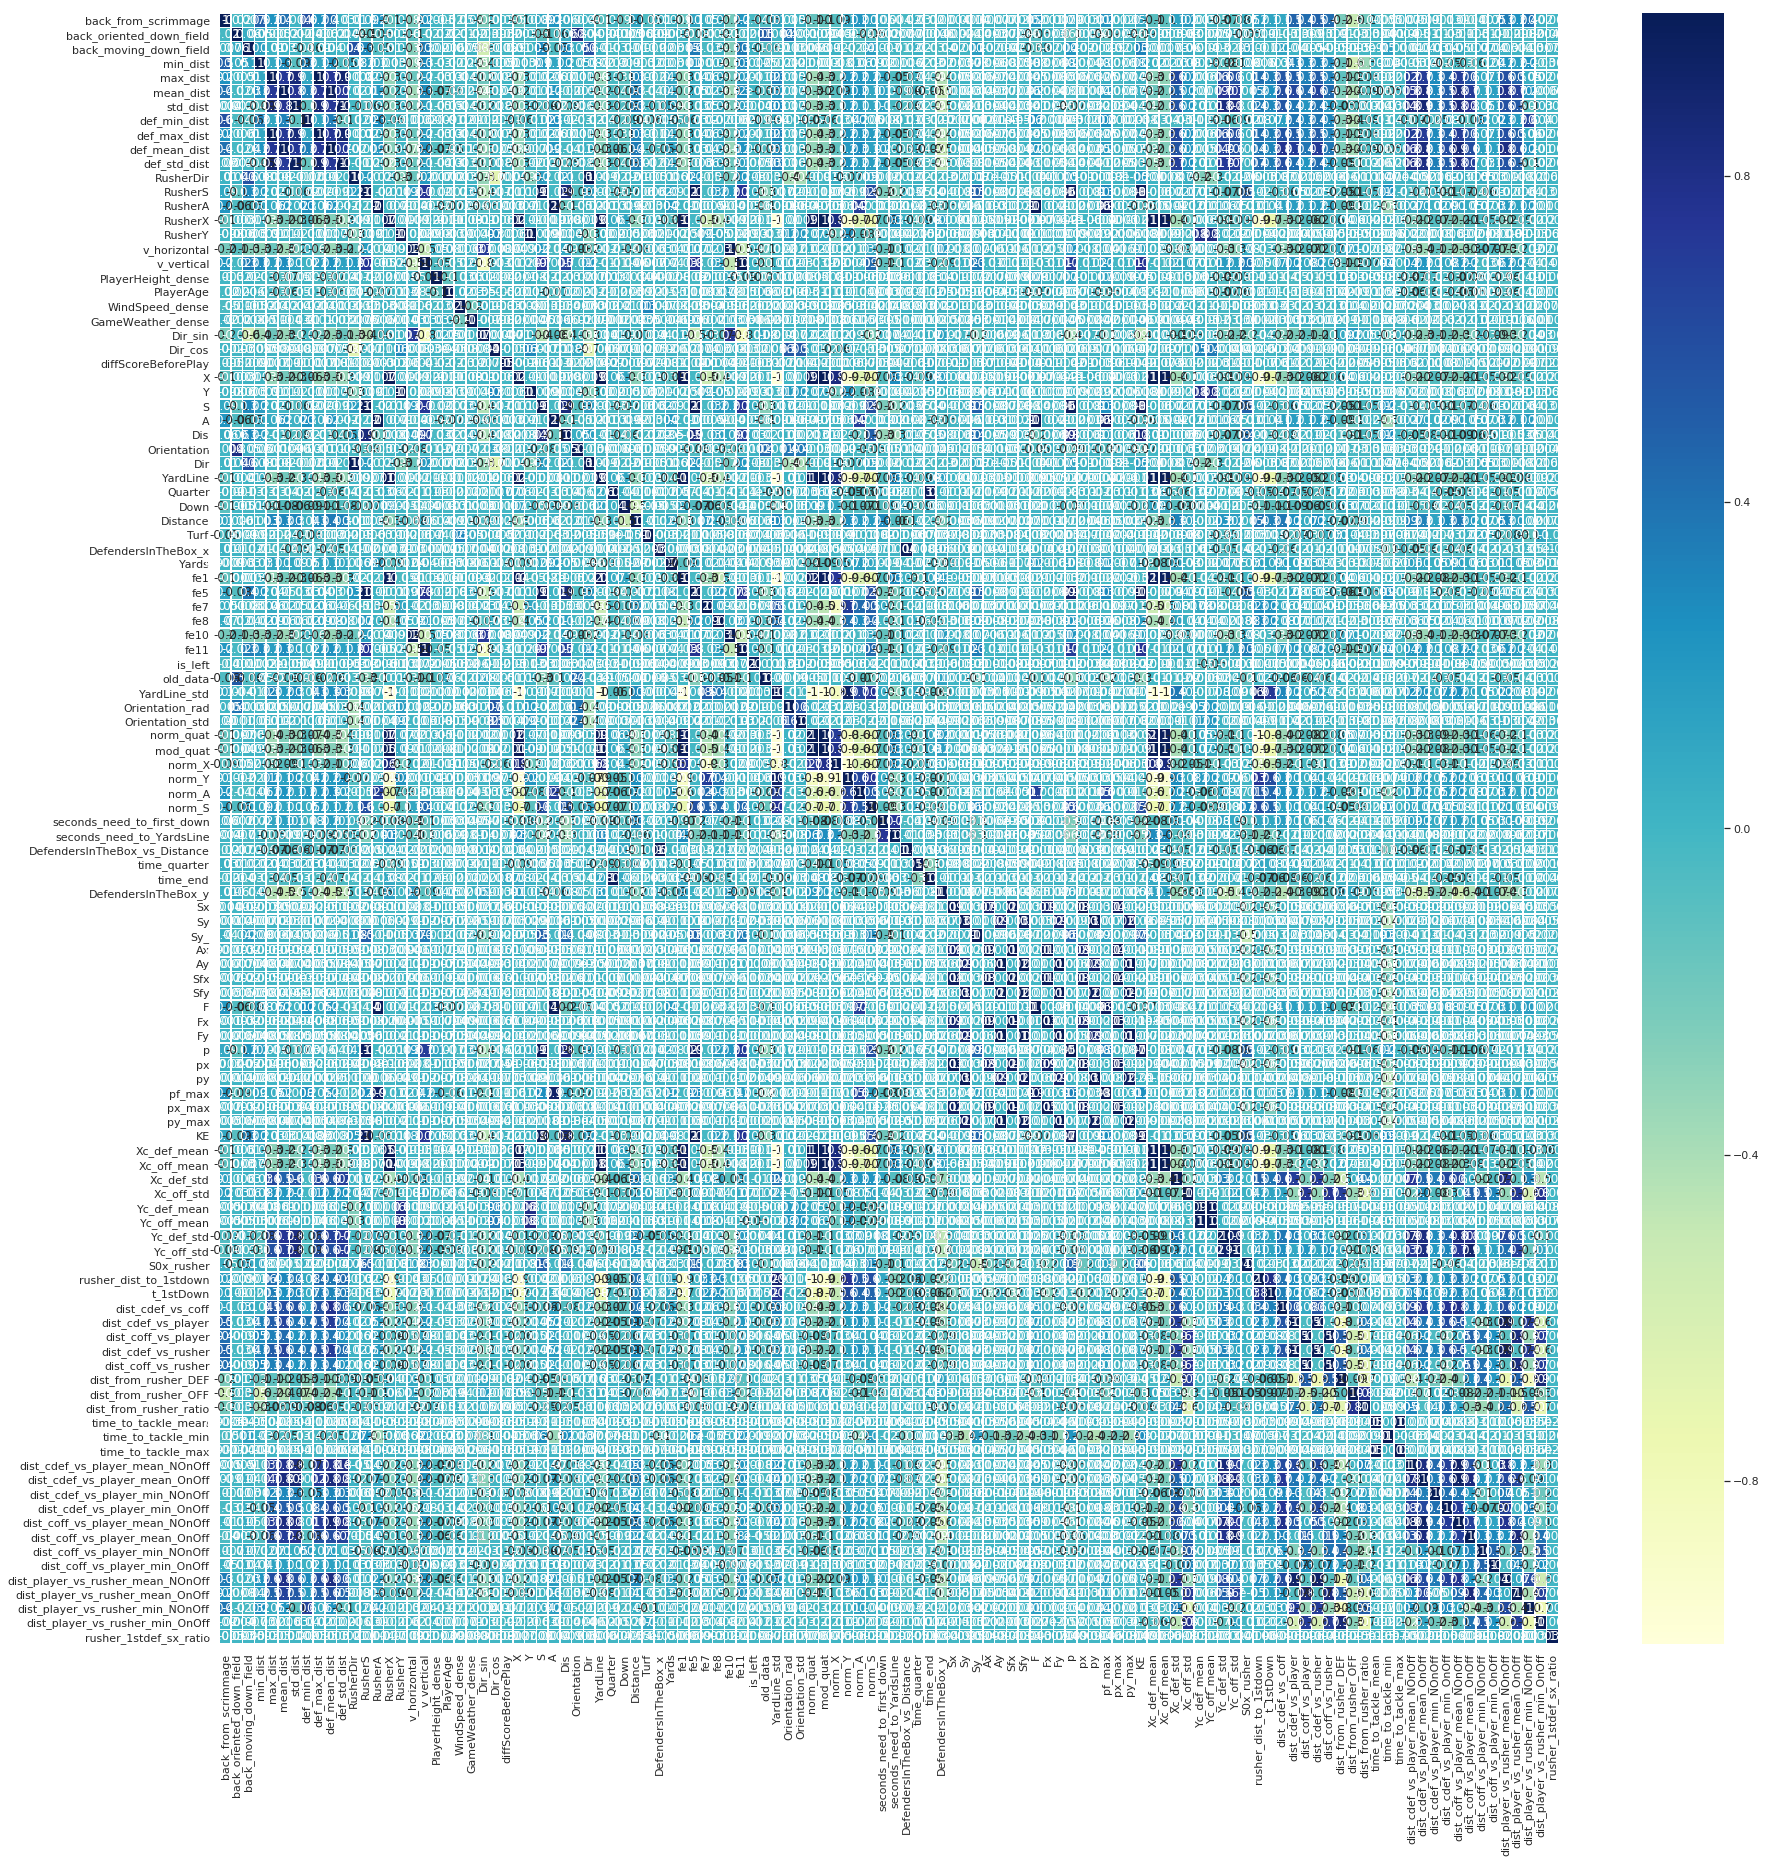

In [27]:
sns.set(rc={'figure.figsize':(30, 30)})
corr = new_X.corr()
plt.figure() 
ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
plt.savefig('corr_heatmap.png')
plt.show()

### Removendo features com alta correlação

In [28]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.99:
            if columns[j]:
                columns[j] = False

best_features_revised = new_X.columns[columns].values
drop_columns = new_X.columns[columns == False].values
print(best_features_revised)
print(drop_columns)

['back_from_scrimmage' 'back_oriented_down_field' 'back_moving_down_field'
 'min_dist' 'max_dist' 'mean_dist' 'std_dist' 'def_min_dist'
 'def_mean_dist' 'def_std_dist' 'RusherDir' 'RusherS' 'RusherA' 'RusherX'
 'RusherY' 'v_horizontal' 'v_vertical' 'PlayerHeight_dense' 'PlayerAge'
 'WindSpeed_dense' 'GameWeather_dense' 'Dir_sin' 'Dir_cos'
 'diffScoreBeforePlay' 'Dis' 'Orientation' 'Quarter' 'Down' 'Distance'
 'Turf' 'DefendersInTheBox_x' 'Yards' 'fe1' 'fe5' 'fe7' 'fe8' 'is_left'
 'old_data' 'YardLine_std' 'Orientation_rad' 'Orientation_std' 'norm_quat'
 'norm_X' 'norm_Y' 'norm_A' 'norm_S' 'seconds_need_to_first_down'
 'seconds_need_to_YardsLine' 'DefendersInTheBox_vs_Distance'
 'time_quarter' 'time_end' 'DefendersInTheBox_y' 'Sx' 'Sy' 'Sy_' 'Ax' 'Ay'
 'F' 'p' 'pf_max' 'KE' 'Xc_def_std' 'Xc_off_std' 'Yc_def_mean'
 'Yc_off_mean' 'Yc_def_std' 'Yc_off_std' 'S0x_rusher'
 'rusher_dist_to_1stdown' 't_1stDown' 'dist_cdef_vs_coff'
 'dist_cdef_vs_player' 'dist_coff_vs_player' 'dist_from_rusher_D

In [29]:
# Visualizando o dataset antes de aplicar Feature Selection
new_X = X.loc[:,best_features_revised]
new_X.head()

back_from_scrimmage  back_oriented_down_field  back_moving_down_field  \
0                 3.75                         1                       0   
1                 4.07                         0                       0   
2                 3.66                         1                       0   
3                 3.53                         0                       0   
4                 5.01                         0                       0   

   min_dist   max_dist  mean_dist  std_dist  def_min_dist  def_mean_dist  \
0  1.449724  22.415872   8.046559  4.873845      4.593310       9.752491   
1  0.792023  23.025872   8.614623  5.598683      4.287773      10.297028   
2  1.646390  20.726285   8.482583  4.642121      4.221670       9.903689   
3  0.918096   9.791231   5.549379  1.983128      4.528002       6.309354   
4  0.502892  21.214806   9.168819  5.611232      4.288088      11.056456   

   def_std_dist  RusherDir  RusherS  RusherA  RusherX  RusherY  v_horizontal  \
0      5.327299     114.26     3.63     3.35    41.25    30.53      3.309436   
1      5.833217      47.80     3.06     2.41    48.93    27.16      2.266862   
2      5.073290     138.04     5.77     2.42    71.34    19.11      3.857889   
3      1.834174      84.56     4.45     3.20   104.47    25.36      4.429957   
4      5.900009     157.92     3.90     2.53    29.99    27.12      1.466013   

   v_vertical  PlayerHeight_dense  PlayerAge  WindSpeed_dense  \
0    1.491487                  70  25.596251              8.0   
1    2.055465                  70  25.596252              8.0   
2    4.290640                  70  25.596253              8.0   
3    0.421875                  71  26.852933              8.0   
4    3.613974                  71  22.091819              8.0   

   GameWeather_dense   Dir_sin   Dir_cos  diffScoreBeforePlay   Dis  \
0                1.0  0.911690 -0.410878                    0  0.38   
1                1.0  0.740805  0.671721                    0  0.34   
2                1.0  0.668612 -0.743612                    0  0.60   
3                1.0  0.995496  0.094803                    0  0.46   
4                1.0  0.375901 -0.926660                    7  0.44   

   Orientation  Quarter  Down  Distance   Turf  DefendersInTheBox_x  Yards  \
0       198.02        1     3         2  False                  6.0      8   
1       149.30        1     1        10  False                  6.0      3   
2       219.18        1     1        10  False                  7.0      5   
3       173.78        1     2         2  False                  9.0      2   
4        34.27        1     1        10  False                  7.0      7   

          fe1      fe5  fe7       fe8  is_left  old_data  YardLine_std  \
0   27.739531  15.7229  0.0  0.130860     True      True          55.0   
1   40.699869  11.0024  0.0  0.075185     True      True          47.0   
2   68.732841  36.1969  0.0  0.083948     True      True          25.0   
3  101.345209  22.7465  0.0  0.043909     True      True          -8.0   
4   12.802566  17.4364  0.0  0.304626    False      True          65.0   

   Orientation_rad  Orientation_std   norm_quat    norm_X    norm_Y    norm_A  \
0         3.456101         0.314508   2658.0428  0.800098  0.592169  0.064978   
1         2.605777         5.747369   3146.9822  0.872224  0.484153  0.042961   
2         3.825413         0.683820   5493.7370  0.962497  0.257826  0.032650   
3         3.033033         6.174626  11587.1530  0.970517  0.235592  0.029728   
4         0.598124         0.598124   1656.5054  0.736852  0.666336  0.062162   

     norm_S  seconds_need_to_first_down  seconds_need_to_YardsLine  \
0  0.070409                    4.812632                 108.284211   
1  0.054547                   26.894118                 142.538824   
2  0.077847                   15.240000                 114.300000   
3  0.041340                    3.975652                 214.685217   
4  0.095823                   20.781818

# Feature Selection

In [30]:
# Importância do Atributo com o Extra Trees Classifier
X_ = new_X.drop(['Yards'], axis=1)
y_ = new_X['Yards']

X_.replace(-np.inf,-999,inplace=True)
X_.replace(np.inf,-999,inplace=True)
X_.fillna(-999,inplace=True)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_ = StandardScaler().fit_transform(X_)

# Criação do Modelo - Feature Selection
modeloRF = RandomForestRegressor(bootstrap=False, 
                                 max_features=0.3, 
                                 min_samples_leaf=15, 
                                 min_samples_split=8, 
                                 n_estimators=50, 
                                 n_jobs=-1, 
                                 random_state=42)
modeloRF.fit(X_, y_)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(new_X.drop(['Yards'], axis=1).columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloRF.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

                              Feature  importance
12                            RusherA    0.062517
58                             pf_max    0.048981
56                                  F    0.044263
15                       v_horizontal    0.028791
69                  dist_cdef_vs_coff    0.024924
21                            Dir_sin    0.024174
60                         Xc_def_std    0.021653
43                             norm_A    0.021380
0                 back_from_scrimmage    0.020394
32                                fe5    0.019460
81    dist_coff_vs_player_mean_NOnOff    0.018550
36                           old_data    0.018087
16                         v_vertical    0.016776
25                        Orientation    0.016085
61                         Xc_off_std    0.015078
59                                 KE    0.014716
77    dist_cdef_vs_player_mean_NOnOff    0.013698
84      dist_coff_vs_player_min_OnOff    0.013596
31                                fe1    0.013240


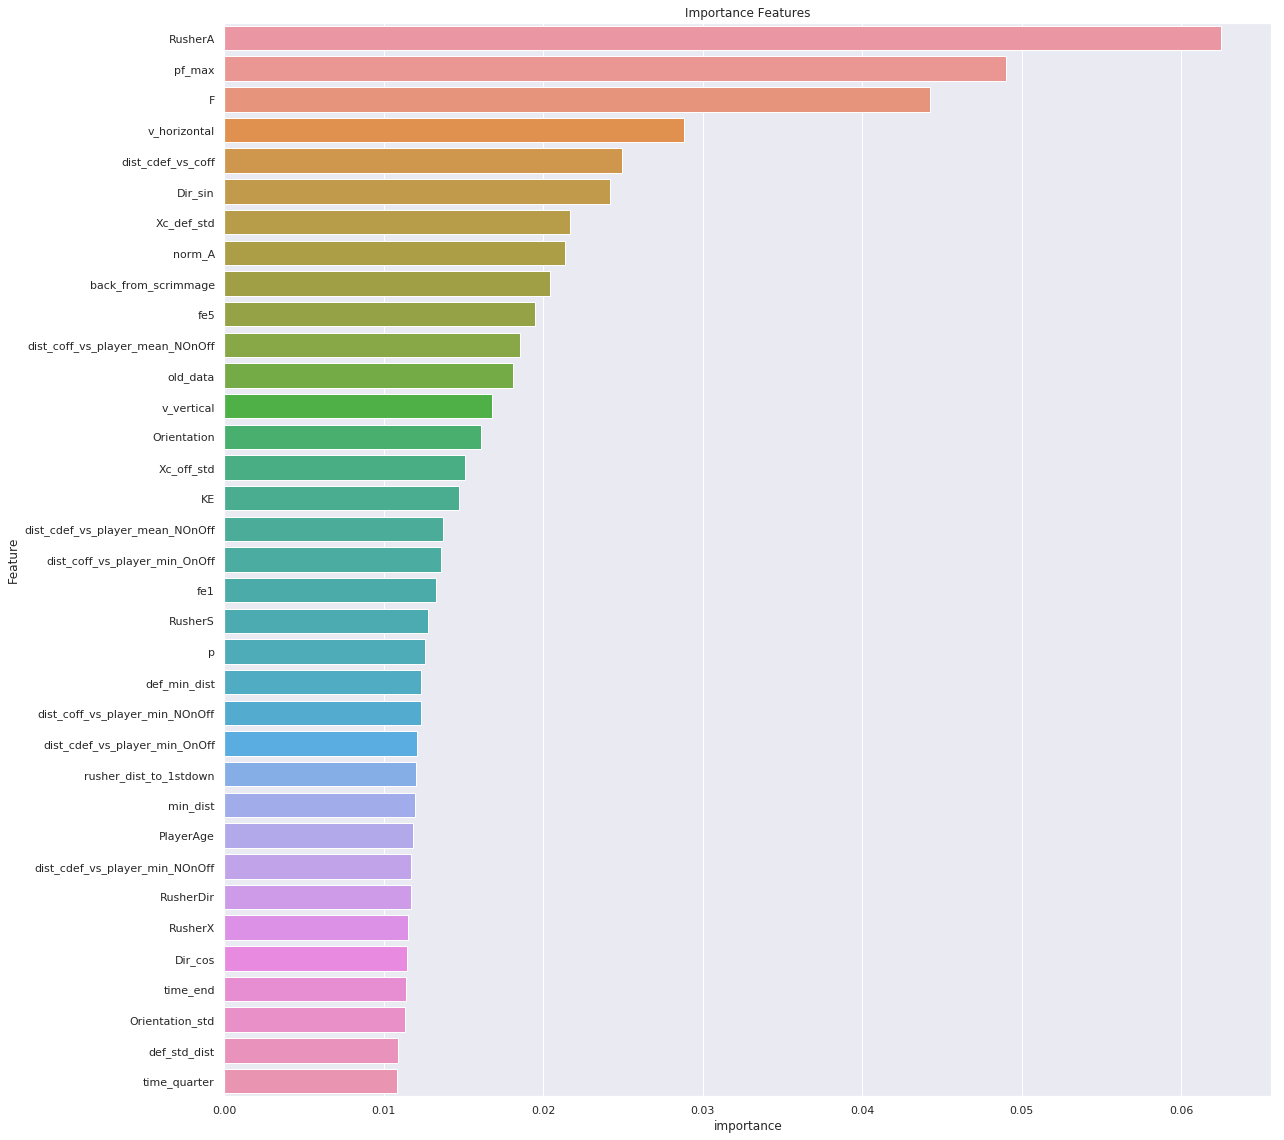

In [31]:
# Imprimindo o gráfico das 35 melhores features que serão utilizadas para treinamento do modelo
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:35].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,16))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

# Criar e avaliar alguns algoritmos de Machine Learning

### Split Treino e Validação

In [32]:
# Criar um dataset somente com as colunas mais importantes conforme Feature Selection
new_X = X.loc[:,best_features['Feature']]

target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)
new_X.shape, y.shape

((23158, 35), (23158, 199))

### Modelo de Redes Neurais

In [33]:
# Funcao de perda para validacao do modelo - CRPS score
def crps_score(y_prediction, y_valid, shape=X.shape[0]):
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_prediction, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * shape)
    crps = np.round(val_s, 6)
    return crps

In [34]:
# Funcao para realizar o acompanhamento do treinamento do modelo de rede neural
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [35]:
from keras.regularizers import l2,l1, l1_l2

def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    inp = Input(shape = (x_tr.shape[1],))
    
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(512, activation='relu', bias_regularizer=l1_l2(l1=0.01,l2=0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(lr = 0.09, decay = 0.01),
                  loss='categorical_crossentropy', 
                  metrics=[])
     
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=15)

    mc = ModelCheckpoint('best_model.h5',
                         monitor='CRPS_score_val',
                         mode='min',
                         save_best_only=True, 
                         verbose=1, 
                         save_weights_only=True)
    
    bsz = 1024
    model.fit(x_tr, y_tr,
              callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc],
              epochs=250, 
              batch_size=bsz,
              verbose=0,
              shuffle=True)
    
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)

    return model,crps

### Realização do Treinamento do Modelo

In [36]:
%%time

loop = 2
fold = 6

oof_nn = np.zeros([loop, y.shape[0], y.shape[1]])
models_nn = []
crps_csv_nn = []

for k in range(loop):
    kfold = KFold(fold, random_state = 123 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = new_X[tr_inds], y[tr_inds]
        val_x, val_y = new_X[val_inds], y[val_inds]
        
        # Train NN
        nn, crps_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold crps (NN) is %f"%((k_fold+1), crps_nn))
        crps_csv_nn.append(crps_nn)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)
        
    print("PARCIAL: mean crps (NN) is %f"%np.mean(crps_csv_nn))        

-----------
Loop 1/2 Fold 1/6
-----------

Epoch 00001: CRPS_score_val improved from inf to 0.15787, saving model to best_model.h5

Epoch 00002: CRPS_score_val improved from 0.15787 to 0.02048, saving model to best_model.h5

Epoch 00003: CRPS_score_val improved from 0.02048 to 0.01532, saving model to best_model.h5

Epoch 00004: CRPS_score_val improved from 0.01532 to 0.01376, saving model to best_model.h5

Epoch 00005: CRPS_score_val improved from 0.01376 to 0.01320, saving model to best_model.h5

Epoch 00006: CRPS_score_val improved from 0.01320 to 0.01315, saving model to best_model.h5

Epoch 00007: CRPS_score_val improved from 0.01315 to 0.01261, saving model to best_model.h5

Epoch 00008: CRPS_score_val improved from 0.01261 to 0.01261, saving model to best_model.h5

Epoch 00009: CRPS_score_val did not improve from 0.01261

Epoch 00010: CRPS_score_val improved from 0.01261 to 0.01255, saving model to best_model.h5

Epoch 00011: CRPS_score_val improved from 0.01255 to 0.01244, savi

### Verificando o resultado do treinamento

In [37]:
crps_oof_nn = []

for k in range(loop):
    crps_oof_nn.append(crps_score(oof_nn[k,...], y))

In [38]:
print("mean crps (NN) is %f"%np.mean(crps_csv_nn))
print("mean OOF crps (NN) is %f"%np.mean(crps_oof_nn))

mean crps (NN) is 0.012384
mean OOF crps (NN) is 0.012383


# Realizar a submissão para o Kaggle

### Criando uma funcao para realizar as predicoes com dados de teste

In [39]:
def predict(x_te, models_nn):
    
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = m.predict(x_te, batch_size=1024)
        else:
            y_pred_nn += m.predict(x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    
    return y_pred_nn

### Preparando os dados de teste e realizando as previsões

In [40]:
%%time

if  TRAIN_OFFLINE==False:
    
    from kaggle.competitions import nflrush
    env = nflrush.make_env()
    iter_test = env.iter_test()
    df_prev = pd.DataFrame()
    df_test = pd.DataFrame()

    for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
        
        basetable_01    = create_features_01(test_df, deploy=True)
        basetable_02    = create_features_02(basetable_01)
        basetable_03, _ = create_features_03(test_df, enc_out, True)
        X = pd.merge(basetable_02, basetable_03, on=['GameId','PlayId'], how='inner')

        # Considerar somente as colunas do Feature Selection
        X = X.loc[:,best_features['Feature']]
        X.fillna(-999,inplace=True)
    
        scaled_basetable = scaler.transform(X)
        
        y_pred = predict(scaled_basetable, models_nn)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

        preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
        
        df_test = df_test.append(X)
        df_prev = df_prev.append(preds_df)
    
        env.predict(preds_df)

    env.write_submission_file()


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
CPU times: user 38min 20s, sys: 29.7 s, total: 38min 50s
Wall time: 37min 41s


In [41]:
df_test.head()

back_from_scrimmage  min_dist  def_min_dist  def_std_dist  RusherDir  \
0                 6.24  2.950254      6.419548      4.484590      24.50   
0                 4.17  0.813941      5.180357      5.894972      53.85   
0                 5.11  0.877838      5.471563      5.345275     126.36   
0                 4.00  0.564004      4.397204      5.122506      50.27   
0                 4.16  0.621289      2.911099      7.899829     173.37   

   RusherS  RusherA  RusherX  v_horizontal  v_vertical  PlayerAge   Dir_sin  \
0     5.96     3.23    28.76      2.471572    5.423369  24.761167  0.414693   
0     3.96     3.03    53.83      3.197603    2.336009  26.543516  0.807475   
0     5.68     3.50    16.89      4.574149    3.367427  24.761190  0.805308   
0     4.21     2.57    70.00      3.237764    2.690908  22.247853  0.769065   
0     5.34     1.43    73.84      0.616542    5.304288  22.247855  0.115457   

    Dir_cos  Orientation        fe1      fe5  old_data  Orientation_std  \
0  0.909961        75.49  10.095182  39.2684     False         6.029938   
0  0.589901        80.59  48.692570  18.0450     False         2.977357   
0 -0.592857       110.44  13.075836  36.1824     False         0.356745   
0  0.639171        93.82  66.050644  19.8315     False         3.208264   
0 -0.993312       133.83  70.024144  30.0314     False         3.906570   

     norm_A  time_quarter  time_end           F           p       pf_max  \
0  0.080793           900         0  278.655626  514.175706  1628.904632   
0  0.051592           753       147  277.738995  362.985618  1460.052604   
0  0.124838           573       327  301.948820  490.019800  1691.645528   
0  0.034775           473       427  236.639945  387.647536  1329.710569   
0  0.018412           432       468  131.671253  491.695450  1041.715701   

            KE  Xc_def_std  Xc_off_std  rusher_dist_to_1stdown  \
0  1401.083550    4.135818    2.147674                    6.24   
0   657.189817    5.359514    2.017527                    4.17   
0  1272.530458    5.135488    2.246265                    5.11   
0   746.148630    4.189609    2.547474                  -24.00   
0  1200.448873    6.547939    2.095338                  -35.84   

   dist_cdef_vs_coff  dist_cdef_vs_player_mean_NOnOff  \
0           3.961762                         6.169051   
0           4.313979                         7.387940   
0           4.901890                         6.774570   
0           4.343737                         7.549118   
0           5.205559                        10.069037   

   dist_cdef_vs_player_min_NOnOff  dist_cdef_vs_player_min_OnOff  \
0                        1.228244                       2.960963   
0                        0.796847                       3.638609   
0                        1.202193                       3.571916   
0                        0.643331                       3.516328   
0                        3.504719                       5.611653   

   dist_coff_vs_player_mean_NOnOff  dist_coff_vs_player_min_NOnOff  \
0                         6.909102                        1.838501   
0                         7.925335                        1.671140   
0                         7.520251                        1.195094   
0                         8.306315                        1.290562   
0                        10.290863                        0.744241   

   dist_coff_vs_player_min_OnOff  
0                       1.161478  
0                       1.210067  
0                       1.256295  
0                       0.810233  
0                       0.756069

In [42]:
df_prev.head()

Yards-99      Yards-98      Yards-97      Yards-96  Yards-95  Yards-94  \
0  1.262874e-06  2.305612e-06  3.680369e-06  4.784345e-06  0.000006  0.000007   
0  3.124710e-07  5.655766e-07  8.406515e-07  1.101067e-06  0.000001  0.000002   
0  7.996484e-07  1.531186e-06  2.403547e-06  3.151509e-06  0.000004  0.000005   
0  2.189899e-07  4.052070e-07  6.193658e-07  8.221570e-07  0.000001  0.000001   
0  2.205523e-06  4.155424e-06  6.317311e-06  8.456653e-06  0.000011  0.000013   

   Yards-93  Yards-92  Yards-91  Yards-90  Yards-89  Yards-88  Yards-87  \
0  0.000008  0.000010  0.000011  0.000012  0.000013  0.000014  0.000015   
0  0.000002  0.000002  0.000002  0.000003  0.000003  0.000003  0.000004   
0  0.000005  0.000006  0.000007  0.000008  0.000008  0.000009  0.000010   
0  0.000001  0.000002  0.000002  0.000002  0.000002  0.000002  0.000003   
0  0.000015  0.000017  0.000019  0.000021  0.000023  0.000025  0.000028   

   Yards-86  Yards-85  Yards-84  Yards-83  Yards-82  Yards-81  Yards-80  \
0  0.000017  0.000018  0.000019  0.000020  0.000022  0.000023  0.000024   
0  0.000004  0.000004  0.000004  0.000005  0.000005  0.000005  0.000005   
0  0.000011  0.000011  0.000012  0.000013  0.000014  0.000015  0.000015   
0  0.000003  0.000003  0.000003  0.000004  0.000004  0.000004  0.000004   
0  0.000030  0.000032  0.000034  0.000036  0.000038  0.000040  0.000042   

   Yards-79  Yards-78  Yards-77  Yards-76  Yards-75  Yards-74  Yards-73  \
0  0.000025  0.000027  0.000028  0.000029  0.000030  0.000031  0.000033   
0  0.000006  0.000006  0.000006  0.000006  0.000007  0.000007  0.000007   
0  0.000016  0.000017  0.000018  0.000018  0.000019  0.000020  0.000021   
0  0.000004  0.000004  0.000005  0.000005  0.000005  0.000005  0.000005   
0  0.000044  0.000046  0.000048  0.000050  0.000052  0.000054  0.000056   

   Yards-72  Yards-71  Yards-70  Yards-69  Yards-68  Yards-67  Yards-66  \
0  0.000034  0.000036  0.000037  0.000038  0.000039  0.000040  0.000042   
0  0.000008  0.000008  0.000008  0.000008  0.000009  0.000009  0.000009   
0  0.000022  0.000022  0.000023  0.000024  0.000025  0.000025  0.000026   
0  0.000006  0.000006  0.000006  0.000006  0.000007  0.000007  0.000007   
0  0.000059  0.000061  0.000063  0.000065  0.000067  0.000069  0.000071   

   Yards-65  Yards-64  Yards-63  Yards-62  Yards-61  Yards-60  Yards-59  \
0  0.000043  0.000044  0.000045  0.000047  0.000048  0.000049  0.000051   
0  0.000009  0.000010  0.000010  0.000010  0.000010  0.000011  0.000011   
0  0.000027  0.000028  0.000028  0.000029  0.000030  0.000031  0.000032   
0  0.000007  0.000007  0.000007  0.000008  0.000008  0.000008  0.000008   
0  0.000073  0.000075  0.000077  0.000079  0.000082  0.000084  0.000086   

   Yards-58  Yards-57  Yards-56  Yards-55  Yards-54  Yards-53  Yards-52  \
0  0.000052  0.000053  0.000054  0.000055  0.000057  0.000058  0.000059   
0  0.000011  0.000011  0.000012  0.000012  0.000012  0.000013  0.000013   
0  0.000032  0.000033  0.000034  0.000035  0.000036  0.000037  0.000037   
0  0.000008  0.000009  0.000009  0.000009  0.000009  0.000010  0.000010   
0  0.000088  0.000090  0.000092  0.000094  0.000096  0.000098  0.000100   

   Yards-51  Yards-50  Yards-49  Yards-48  Yards-47  Yards-46  Yards-45  \
0  0.000060  0.000062  0.000063  0.000064  0.000065  0.000066  0.000068   
0  0.000013  0.000014  0.000014  0.000014  0.000014  0.000015  0.000015   
0  0.000038  0.000039  0.000040  0.000041  0.000041  0.000042  0.000043   
0  0.000010  0.000010  0.000010  0.000011  0.000011  0.000011  0.000011   
0  0.000102  0.000104  0.000106  0.000108  0.000110  0.000112  0.000114   

   Yards-44  Yards-43  Yards-42  Yards-41  Yards-40  Yards-39  Yards-38  \
0  0.000069  0.000070  0.000071  0.000073  0.000074  0.000075  0.000076   
0  0.000015  0.000015  0.000016  0.000016  0.000016  0.000016  0.000017   
0  0.000044  0.000044  0.000045  0.000046  0.000047  0.000047  0.000048   
0  0.000011  0.000012  0.000012  0.000012  0.000012  0.000012  